In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Formatting
After importing the data into a pandas database, I make several adjustments to column names, indexing, dataframe size, NaN variables etc. in order to make my data appropriate and usable for my model. These formatting adjustments resulted in several samples being dropped due to the lack of samples that were available in the indepenedent dataframes.

In [13]:
import numpy as np
import pandas as pd

#Import csv of match, team and attribute data
mdata = pd.read_csv("/content/gdrive/MyDrive/Matches.csv", encoding = "ISO-8859-1")
tdata = pd.read_csv("/content/gdrive/MyDrive/Team.csv", encoding = "ISO-8859-1")
adata = pd.read_csv("/content/gdrive/MyDrive/Team_Attributes.csv", encoding = "ISO-8859-1")

#Format team data
tdata = pd.DataFrame(np.vstack([tdata.columns, tdata]))
tdata = tdata.dropna()
tdata = tdata.reset_index()
tdata = tdata[[1,2,3,4]]
tdata.columns = ["Team ID", "Attribute ID", "Team Name", "Team Abbreviation"]

#Format match data
mdata = pd.DataFrame(np.vstack([mdata.columns, mdata]))
mdata = mdata[[6,7,8,9,10]]
mdata.columns = ["Match ID", "Home Team ID", "Away Team ID", "Home Team Score", "Away Team Score"]
mdata = mdata.drop(columns='Match ID')
mdata.at[0, 'Home Team Score'] = 1
mdata.at[0, 'Away Team Score'] = 1

#Adds additional column on the result according to the home team
conditions = [(mdata['Home Team Score'] < mdata['Away Team Score']), (mdata['Home Team Score'] == mdata['Away Team Score']), (mdata['Home Team Score'] > mdata['Away Team Score'])]
values = ['L', 'D', 'W']
mdata['Result'] = np.select(conditions, values)

#Format attribute data
adata = pd.DataFrame(np.vstack([adata.columns, adata]))
adata = adata.drop(columns=[0,3])
adata.columns = ["Attribute ID", "Team ID", "Build Up Play Speed", "Build Up Play Speed Class", "Build Up Play Dribbling", "Build Up Play Dribbling Class", "Build Up Play Passing", "Build Up Play Passing Class", "Build Up Play Positioning Class", "Chance Creation Passing", "Chance Creation Passing Class", "Chance Creation Crossing", "Chance Creation Crossing Class", "Chance Creation Shooting", "Chance Creation Shooting Class", "Chance Creation Positioning Class", "Defence Pressure", "Defence Pressure Class", "Defence Aggression", "Defence Aggression Class", "Defence Team Width", "Defence Team Width Class", "Defence Defender Line Class"]
adata = adata.drop_duplicates(subset="Attribute ID", keep='last')
adata = adata.drop(index=adata.index[0], axis=0)
adata = adata.reset_index()
adata = adata.drop(columns="index")

#Combine and format attribute and team data
tadata = tdata.merge(adata, on = "Team ID") 
tadata = tadata.drop(columns=["Attribute ID_x", "Attribute ID_y"])

#Comdine match and team attribute data
atadata = tadata.add_prefix('Away ')
htadata = tadata.add_prefix('Home ')
mtadata = pd.merge(mdata, atadata, on='Away Team ID', how='right')
mtadata = pd.merge(mtadata, htadata, on='Home Team ID', how='right')

mtadata

(25101, 51)

#Pre-processing

After all of my data was formatted, I had to encode the categorial features that needs to be used in the machine learning model along with filling the NaN values left for features that are to be used in the machine learning model. 

In [14]:
#Replace nan with their most frequent column value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer = imputer.fit(mtadata.iloc[:, 7:50])
mtadata.iloc[:, 7:50] = imputer.transform(mtadata.iloc[:, 7:50])

#Encode text features
dummy = pd.get_dummies(mtadata.iloc[:,[8,10,12,13,15,17,19,20,22,24,26,27,31,33,35,36,38,40,42,43,45,47,49,50]])
mtadata = mtadata.drop(mtadata.iloc[:,[8,10,12,13,15,17,19,20,22,24,26,27,31,33,35,36,38,40,42,43,45,47,49,50]], axis=1)
mtadata = pd.concat([mtadata, dummy], axis=1)

#Resort the columns
cols = list(mtadata.columns.values) 
cols.pop(cols.index('Away Team Name')) 
cols.pop(cols.index('Away Team Abbreviation'))
cols.pop(cols.index('Home Team Name')) 
cols.pop(cols.index('Home Team Abbreviation'))  
mtadata = mtadata[['Away Team Name','Away Team Abbreviation','Home Team Name','Home Team Abbreviation']+cols] 

#Encode the label
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(categories=[['L', 'D', 'W']])
oe.fit(mtadata[['Result']])
resultcat = oe.transform(mtadata[['Result']])
mtadata.insert(9, 'Result Enc', resultcat)

mtadata

#Modeling


Now that the data frame is finalized, I implemented models to predict the classification of the outcome of a match between two teams.

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

#Seperate the features and the label
X = mtadata.iloc[:,10:93]
y = mtadata['Result Enc']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60)

##Naive Bayes
These are naive bayes models applied to my data frame in order to predict the outcome of a match.

[0.40410277 0.33964143 0.4189243  0.37788845 0.37370518]
Accuracy: 0.38 (+/- 0.05)


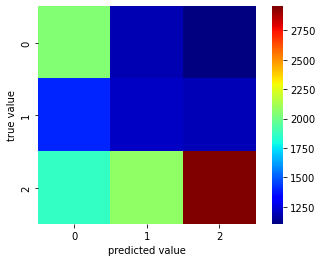

In [16]:
from sklearn.naive_bayes import GaussianNB  
GNB = GaussianNB()  
GNB.fit(X_train, y_train)
y_pred = GNB.predict(X_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(GNB, X, y, cv=5)

print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=False, cbar=True, cmap='jet') #flag, YlGnBu, jet
plt.xlabel('predicted value')
plt.ylabel('true value');

[0.43636726 0.4498008  0.42689243 0.41474104 0.42390438]
Accuracy: 0.43 (+/- 0.02)


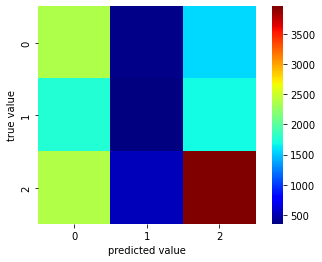

In [17]:
#Better classifier for imbalanced data sets
from sklearn.naive_bayes import ComplementNB 
CNB = ComplementNB()  
CNB.fit(X_train, y_train)
y_pred = CNB.predict(X_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(CNB, X, y, cv=5)

print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=False, cbar=True, cmap='jet') #flag, YlGnBu, jet
plt.xlabel('predicted value')
plt.ylabel('true value');

[0.45389365 0.4438247  0.46752988 0.41533865 0.47749004]
Accuracy: 0.45 (+/- 0.04)


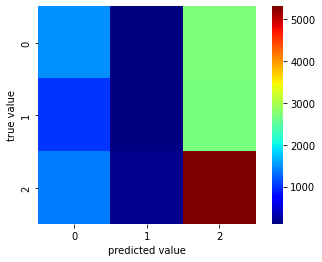

In [18]:
#Better classifier for binary or boolean features
from sklearn.naive_bayes import BernoulliNB  
BNB = BernoulliNB()  
BNB.fit(X_train, y_train)
y_pred = BNB.predict(X_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(BNB, X, y, cv=5)

print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=False, cbar=True, cmap='jet') #flag, YlGnBu, jet
plt.xlabel('predicted value')
plt.ylabel('true value');

[0.46604262 0.47709163 0.46095618 0.42609562 0.45996016]
Accuracy: 0.46 (+/- 0.03)


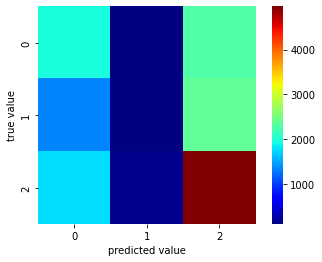

In [19]:
#Better classifier for discrete data
from sklearn.naive_bayes import MultinomialNB  
MNB = MultinomialNB()  
MNB.fit(X_train, y_train)
y_pred = MNB.predict(X_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(MNB, X, y, cv=5)

print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=False, cbar=True, cmap='jet') #flag, YlGnBu, jet
plt.xlabel('predicted value')
plt.ylabel('true value');

##Support Vector Machines (SVM)
Unfortunately, with a large dataset, (see below), and the fact that most SVM algorithms scale super linearly with the number of data points. The runtime of the training doesn't complete in a feasbile amount of time.

In [20]:
mtadata.shape

(25101, 94)

Disclaimer: Not for commercial use. Sourced from:

http://football-data.mx-api.enetscores.com/ : scores and team formation

http://sofifa.com/ : players and teams attributes from EA Sports FIFA games. FIFA series and all FIFA assets property of EA Sports.

Data collection and processing has been done by:
https://www.kaggle.com/hugomathien